<div class="alert alert-block alert-info">
    <h1>Importing packages</h1>
</div>

In [2]:
%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import os
import sys
import pickle
import pywt
import scipy
import xgboost as xgb
import warnings
import tensorflow as tf
from scipy.io import loadmat, savemat
from scipy import signal
from scipy import stats
from IPython.display import Image
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import make_pipeline, Pipeline
from numpy import linalg as LA 
from collections import Counter, defaultdict
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.metrics import categorical_accuracy
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
#from scikeras.wrappers import KerasClassifier

Populating the interactive namespace from numpy and matplotlib


<div class="alert alert-block alert-info">
    <h1>Plot ROC Curves</h1>
</div>

In [3]:
# Compute ROC curve and ROC area for each class
def plot_roc_auc_curve(y_test, y_score_decision, classes, classifier):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test[:, i], y_score_decision[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Compute micro-average ROC curve and ROC area
    # ravel return a flatten array of dataframe
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_decision.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure(figsize=(9,6))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro média (área = {roc_auc["micro"]:.2f})', linewidth=4)
    
    for i in classes:
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (área = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC '+ classifier)
    plt.legend(loc="lower right")
    plt.savefig(os.path.abspath('./images/roc_auc_'+classifier+'.pdf'), dpi=300)
    plt.show()

In [42]:
# Compute ROC curves for all classifiers
def plot_all_roc_auc_curves(y_test, y_score_decision, classifiers):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute micro-average ROC curve and ROC area
    # ravel return a flatten array of dataframe    
    for decision, classifiers_ in zip(y_score_decision,classifiers):
        fpr[classifiers_], tpr[classifiers_], _ = roc_curve(y_test.ravel(), decision.ravel())
        roc_auc[classifiers_] = auc(fpr[classifiers_], tpr[classifiers_])

    # Plot ROC curve
    plt.figure(figsize=(12,8))
    
    for classifiers_ in classifiers:
        plt.plot(fpr[classifiers_], tpr[classifiers_], label=f'{classifiers_} (área = {roc_auc[classifiers_]:.2f})', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    #plt.title('Comparativos de Curvas ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.savefig(os.path.abspath('./images/roc_auc_all_non_normalization.pdf'), dpi=300)
    plt.show()

<div class="alert alert-block alert-info">
    <h1>Loading files</h1>
</div>

In [5]:
#using beats with dwt sym9 function denoise
df_train = pd.read_csv(os.path.abspath('./dataset/MIT_feat_extracted/non_normalization/df_beats_train_dwt_db14.csv'),header=0, index_col=[0])
df_test = pd.read_csv(os.path.abspath('./dataset/MIT_feat_extracted/non_normalization/df_beats_test_dwt_db14.csv'),header=0, index_col=[0])

In [6]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,type_beat
0,4.110874,0,10,-0.604450,-0.578498,-0.559761,-0.552918,-0.564654,-0.570032,0.016960,...,1.004545e-08,1.079164e-05,-1.721515e-10,-3.670798e-12,0.000009,9.010154e-11,0.000003,14.421633,-0.016531,N
1,4.110874,0,3,-0.539610,-0.536041,-0.419079,-0.376006,-0.512322,-0.483997,0.059599,...,4.340028e-09,1.196354e-05,1.771941e-10,-4.342513e-12,0.000010,1.088246e-10,0.000004,15.846909,0.061702,N
2,4.110874,0,5,-0.366957,-0.358665,-0.318583,-0.299862,-0.334531,-0.335753,0.022440,...,4.574423e-09,6.262465e-07,6.393569e-10,-9.145549e-12,0.000010,9.274462e-11,0.000002,26.405583,-0.752717,N
3,4.110874,0,7,-0.466258,-0.455706,-0.367655,-0.352899,-0.396769,-0.405929,0.042315,...,5.215524e-09,5.364911e-06,-1.745952e-10,1.133379e-11,0.000004,1.364688e-11,0.000001,10.238367,-0.133037,N
4,4.110874,0,5,-0.469871,-0.461266,-0.415642,-0.367008,-0.453317,-0.435701,0.033410,...,3.279908e-09,7.981469e-07,7.440704e-11,-7.770240e-12,0.000004,1.871986e-11,0.000001,34.439035,1.447392,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50993,4.110874,2,7,-1.645057,-1.101385,-0.652121,-0.635047,-0.717947,-0.875602,0.383112,...,3.276801e-08,2.856824e-06,-7.056537e-11,-4.574468e-11,0.000114,1.308547e-08,0.000024,42.893361,1.598537,F
50994,4.110874,2,3,-1.761832,-1.024602,-0.672037,-0.306203,-0.734347,-0.870766,0.457138,...,2.865042e-08,1.863300e-06,1.150316e-09,6.897491e-11,0.000044,1.936931e-09,0.000011,30.001597,1.019354,F
50995,4.110874,0,6,-1.116447,-0.933332,-0.906662,-0.787174,-0.909037,-0.936475,0.116167,...,8.485294e-09,5.035342e-08,-3.501161e-11,-2.912289e-11,0.000035,1.241789e-09,0.000008,28.497408,1.341853,F
50996,4.110874,0,11,-0.971133,-0.727148,-0.535486,-0.355158,-0.635562,-0.631869,0.186320,...,8.077943e-08,4.523060e-06,-5.893751e-10,4.804008e-10,0.000114,1.308173e-08,0.000022,46.870254,1.711337,F


In [7]:
#removing classes F and Q
df_train = df_train.query('type_beat != ["F","Q"]')
df_test = df_test.query('type_beat != ["F","Q"]')

In [8]:
#splitting the train dataset
X_train,y_train = df_train.drop(['type_beat'],axis=1), df_train[['type_beat']]

In [9]:
#splitting the test dataset
X_test,y_test = df_test.drop(['type_beat'],axis=1), df_test[['type_beat']]

In [10]:
#counting the classes 
Counter(df_train['type_beat'])

Counter({'N': 45844, 'S': 944, 'V': 3788})

In [11]:
#counting the classes 
Counter(df_test['type_beat'])

Counter({'N': 44238, 'S': 1837, 'V': 3220})

In [12]:
#applying SMOTE in training set of dwt denoise

#pipeline = make_pipeline(SMOTE(sampling_strategy={'N': 45844, 'S': 4000, 'V': 4000}),
#                        RandomUnderSampler(sampling_strategy={'N': 4000, 'S': 4000, 'V': 4000}))
#X_train_smote, y_train_smote = pipeline.fit_resample(X_train,y_train)

In [13]:
#reshape the dataframes of data and target
X = X_train.values.astype(float)
y = y_train.values.squeeze()

In [14]:
#reshape the dataframes of data and target
X_t = X_test.values.astype(float)
y_t = y_test.values.squeeze()

In [15]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

In [16]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_t)
encoded_y_test = encoder.transform(y_t)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

<div class="alert alert-block alert-info">
    <h1>Classification</h1>
</div>

# Neural network

In [17]:
# define baseline model
def model_1(X):
    
    model = Sequential()
    model.add(Dense(10, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
#stop training when loss has stopped improving after 10 epochs
es = EarlyStopping(monitor='loss', 
                   mode='min',
                   patience=10, 
                   restore_best_weights=True)

In [19]:
model = model_1(X)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                570       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X, 
                    dummy_y, 
                    epochs=8000000, 
                    callbacks=[es], 
                    batch_size=10, 
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/8000000
4046/4046 [==============================] - 6s 1ms/step - loss: 0.4328 - accuracy: 0.9696 - val_loss: 24.0563 - val_accuracy: 0.5322
Epoch 2/8000000
4046/4046 [==============================] - 5s 1ms/step - loss: 4.2184e-06 - accuracy: 1.0000 - val_loss: 24.9763 - val_accuracy: 0.5322
Epoch 3/8000000
4046/4046 [==============================] - 5s 1ms/step - loss: 4.8235e-07 - accuracy: 1.0000 - val_loss: 26.0893 - val_accuracy: 0.5322
Epoch 4/8000000
4046/4046 [==============================] - 5s 1ms/step - loss: 6.7455e-08 - accuracy: 1.0000 - val_loss: 27.1629 - val_accuracy: 0.5322
Epoch 5/8000000
4046/4046 [==============================] - 5s 1ms/step - loss: 9.3028e-09 - accuracy: 1.0000 - val_loss: 28.0270 - val_accuracy: 0.5322
Epoch 6/8000000
4046/4046 [==============================] - 5s 1ms/step - loss: 1.7598e-09 - accuracy: 1.0000 - val_loss: 28.8052 - val_accuracy: 0.5322
Epoch 7/8000000
4046/4046 [==============================] - 5s 1ms/step - loss:

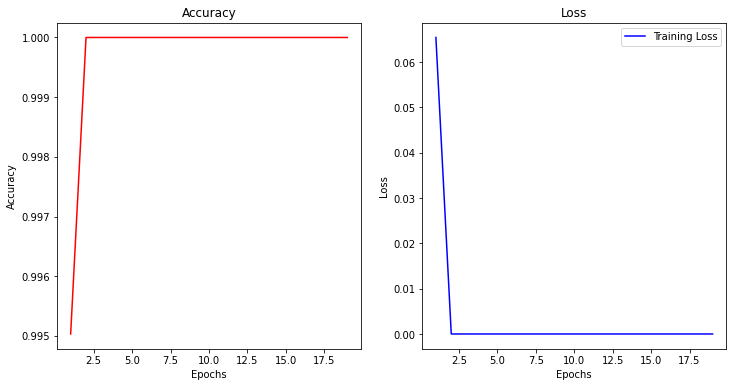

In [27]:
history_dict = history.history

# learning curves
acc = history_dict['accuracy']
loss = history_dict['loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[1].plot(epochs, loss, 'b', label='Training Loss')

ax[0].set_title('Accuracy')
ax[1].set_title('Loss')

ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')

ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')

plt.legend()
plt.show()

In [28]:
loss, accuracy = model.evaluate(X_t,
                                dummy_y_test,
                                batch_size=128, 
                                verbose=1)
print('\n')
print(f'Accuracy: {(accuracy*100):.2f} ({loss:.2f})')

386/386 [==============================] - 0s 868us/step - loss: 6.1307 - accuracy: 0.8974


Accuracy: 89.74 (6.13)


In [29]:
# make class predictions with the model
y_train_pred_ann = model.predict(X)
y_test_pred_ann = model.predict(X_t)

In [30]:
#getting the report of training set
print(classification_report(dummy_y.argmax(axis=1), y_train_pred_ann.argmax(axis=1), zero_division=0))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     45844
           1       0.00      0.00      0.00       944
           2       0.00      0.00      0.00      3788

    accuracy                           0.91     50576
   macro avg       0.30      0.33      0.32     50576
weighted avg       0.82      0.91      0.86     50576



In [31]:
print(classification_report(dummy_y_test.argmax(axis=1), y_test_pred_ann.argmax(axis=1), zero_division=0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     44238
           1       0.00      0.00      0.00      1837
           2       0.00      0.00      0.00      3220

    accuracy                           0.90     49295
   macro avg       0.30      0.33      0.32     49295
weighted avg       0.81      0.90      0.85     49295



Text(609.9818181818181, 0.5, 'True label')

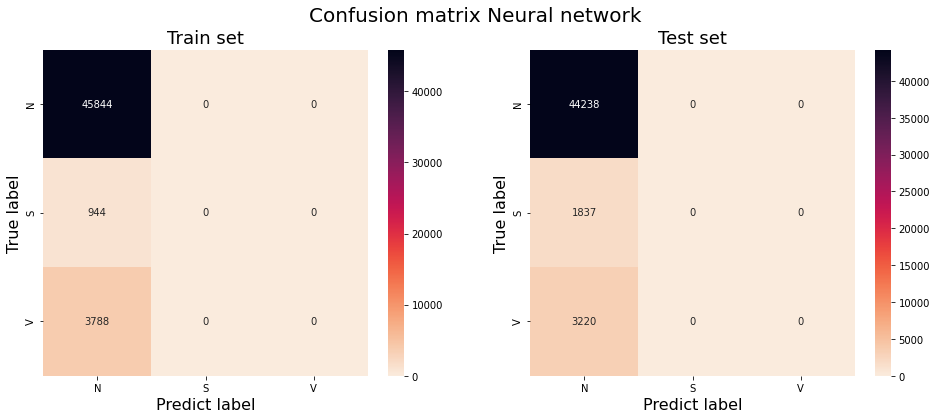

In [32]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_ann = confusion_matrix(dummy_y.argmax(axis=1), y_train_pred_ann.argmax(axis=1))
matrix_test_ann = confusion_matrix(dummy_y_test.argmax(axis=1), y_test_pred_ann.argmax(axis=1))

sns.heatmap(matrix_train_ann, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_ann, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix Neural network', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

# XGradient Boost

In [33]:
scv =  StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores_ = {'accuracy' : metrics.make_scorer(metrics.accuracy_score),
           'recall'   : metrics.make_scorer(metrics.recall_score, average='weighted', zero_division=0),
           'precision': metrics.make_scorer(metrics.precision_score, average='weighted', zero_division=0),
           'f1'       : metrics.make_scorer(metrics.fbeta_score, beta = 2, average='weighted' )}

In [34]:
xgboost = xgb.XGBClassifier(n_estimator=1000, 
                            random_state=1, 
                            n_jobs=-1,                             
                            learning_rate=0.1)

In [89]:
xgboost_result = cross_validate(xgboost, 
                                X_train, 
                                y_train, 
                                scoring=scores_, 
                                cv=scv, 
                                n_jobs=-1,
                                return_train_score=True)

In [112]:
print('Metrics using 10-fold validation')
print(f"Accuracy: {xgboost_result['test_accuracy'].mean():.2f}")
print(f"Recall: {xgboost_result['test_recall'].mean():.2f}")
print(f"Precision: {xgboost_result['test_precision'].mean():.2f}")
print(f"F1-score: {xgboost_result['test_f1'].mean():.2f}")

Metrics using 10-fold validation
Accuracy: 0.96
Recall: 0.96
Precision: 0.96
F1-score: 0.96


In [35]:
xgboost.fit(X,y)

/media/share/comum/env/nevasca/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:45] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:24:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=1000, n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [92]:
train_pred_xgb = xgboost.predict(X_train)
test_pred_xgb = xgboost.predict(X_test)

In [93]:
print(classification_report(y_train, train_pred_xgb))

              precision    recall  f1-score   support

           N       0.98      1.00      0.99     45844
           S       0.98      0.61      0.75       944
           V       0.96      0.85      0.90      3788

    accuracy                           0.98     50576
   macro avg       0.97      0.82      0.88     50576
weighted avg       0.98      0.98      0.98     50576



In [94]:
print(classification_report(y_test, test_pred_xgb))

              precision    recall  f1-score   support

           N       0.92      0.89      0.91     44238
           S       0.02      0.00      0.00      1837
           V       0.26      0.53      0.35      3220

    accuracy                           0.84     49295
   macro avg       0.40      0.47      0.42     49295
weighted avg       0.85      0.84      0.84     49295



Text(609.9818181818181, 0.5, 'True label')

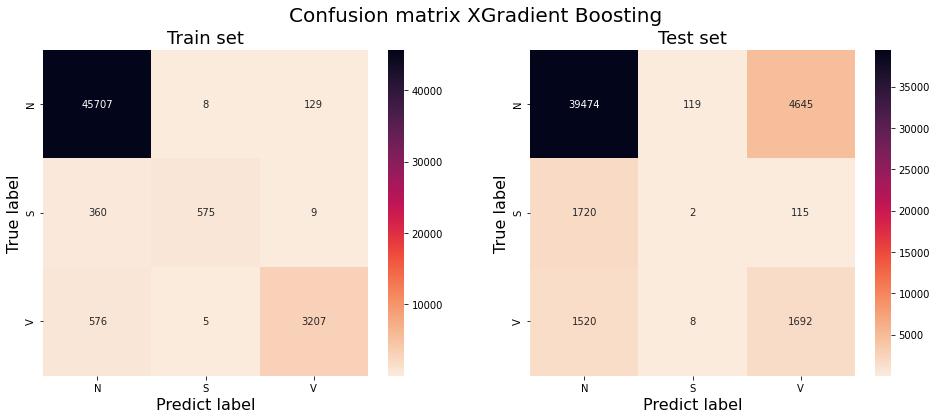

In [95]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_xgb = confusion_matrix(y_train, train_pred_xgb, labels=xgboost.classes_)
matrix_test_xgb = confusion_matrix(y_test, test_pred_xgb, labels=xgboost.classes_)

sns.heatmap(matrix_train_xgb, ax=ax[0],
            xticklabels=xgboost.classes_, 
            yticklabels=xgboost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_xgb, ax=ax[1],
            xticklabels=xgboost.classes_, 
            yticklabels=xgboost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix XGradient Boosting', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)
#plt.savefig(os.path.abspath('./images/confusion_xgradient_boosting.pdf'), dpi=300)

# Gradient Boost

In [36]:
grdboost = GradientBoostingClassifier(n_estimators=200,
                                       random_state=1)

In [105]:
grd_result = cross_validate(grdboost, 
                            X_train, 
                            y_train, 
                            scoring=scores_, 
                            cv=scv, 
                            n_jobs=-1,
                            return_train_score=True)

In [113]:
print('Metrics using 10-fold validation')
print(f"Accuracy: {grd_result['test_accuracy'].mean():.2f}")
print(f"Recall: {grd_result['test_recall'].mean():.2f}")
print(f"Precision: {grd_result['test_precision'].mean():.2f}")
print(f"F1-score: {grd_result['test_f1'].mean():.2f}")

Metrics using 10-fold validation
Accuracy: 0.95
Recall: 0.95
Precision: 0.94
F1-score: 0.94


In [37]:
grdboost.fit(X,y)

GradientBoostingClassifier(n_estimators=200, random_state=1)

In [108]:
train_pred_grd = grdboost.predict(X_train)
test_pred_grd = grdboost.predict(X_test)

In [109]:
print(classification_report(y_train, train_pred_grd))

              precision    recall  f1-score   support

           N       0.96      0.99      0.98     45844
           S       0.92      0.35      0.50       944
           V       0.91      0.68      0.78      3788

    accuracy                           0.96     50576
   macro avg       0.93      0.67      0.75     50576
weighted avg       0.96      0.96      0.95     50576



In [110]:
print(classification_report(y_test, test_pred_grd))

              precision    recall  f1-score   support

           N       0.92      0.90      0.91     44238
           S       0.12      0.00      0.01      1837
           V       0.24      0.43      0.31      3220

    accuracy                           0.84     49295
   macro avg       0.43      0.45      0.41     49295
weighted avg       0.84      0.84      0.84     49295



Text(609.9818181818181, 0.5, 'True label')

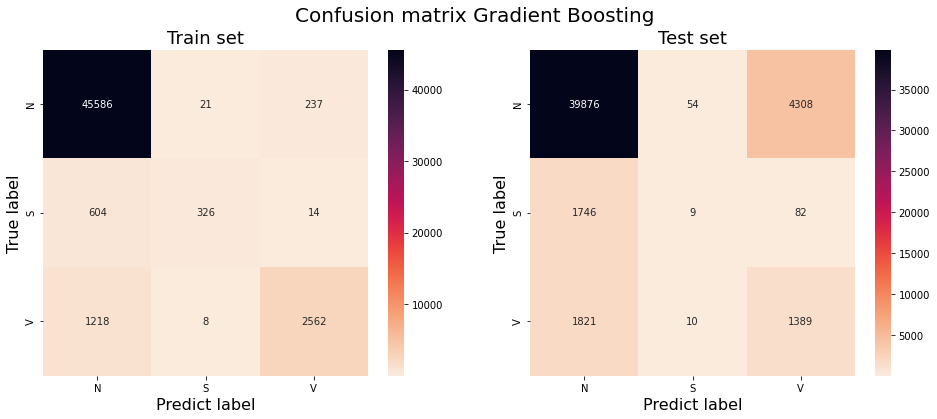

In [111]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_grd = confusion_matrix(y_train, train_pred_grd, labels=grdboost.classes_)
matrix_test_grd = confusion_matrix(y_test, test_pred_grd, labels=grdboost.classes_)

sns.heatmap(matrix_train_grd, ax=ax[0],
            xticklabels=grdboost.classes_, 
            yticklabels=grdboost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_grd, ax=ax[1],
            xticklabels=grdboost.classes_, 
            yticklabels=grdboost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix Gradient Boosting', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)
#plt.savefig(os.path.abspath('./images/confusion_xgradient_boosting.pdf'), dpi=300)

# SVM

In [38]:
#fitting the svm with training set
svm_scaler = SVC(C=13.4, 
                 kernel='rbf', 
                 gamma=0.2)

In [129]:
svm_result = cross_validate(svm_scaler, 
                            X_train, 
                            y_train, 
                            scoring=scores_, 
                            cv=scv, 
                            n_jobs=-1,
                            return_train_score=True)

In [130]:
print('Metrics using 10-fold validation')
print(f"Accuracy: {svm_result['test_accuracy'].mean():.2f}")
print(f"Recall: {svm_result['test_recall'].mean():.2f}")
print(f"Accuracy: {svm_result['test_precision'].mean():.2f}")
print(f"Accuracy: {svm_result['test_f1'].mean():.2f}")

Metrics using 10-fold validation
Accuracy: 0.91
Recall: 0.91
Accuracy: 0.87
Accuracy: 0.89


In [39]:
svm_scaler.fit(X,y)

SVC(C=13.4, gamma=0.2)

In [132]:
train_pred_svm = svm_scaler.predict(X_train)
test_pred_svm = svm_scaler.predict(X_test)

In [133]:
print('REPORT OF TRAINING SET')
print(classification_report(y_train,train_pred_svm))

REPORT OF TRAINING SET
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     45844
           S       1.00      1.00      1.00       944
           V       1.00      1.00      1.00      3788

    accuracy                           1.00     50576
   macro avg       1.00      1.00      1.00     50576
weighted avg       1.00      1.00      1.00     50576



In [134]:
print('REPORT OF TEST SET')
print(classification_report(y_test,test_pred_svm))

REPORT OF TEST SET


/media/share/comum/env/cisco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/share/comum/env/cisco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           N       0.90      1.00      0.95     44238
           S       0.00      0.00      0.00      1837
           V       0.00      0.00      0.00      3220

    accuracy                           0.90     49295
   macro avg       0.30      0.33      0.32     49295
weighted avg       0.81      0.90      0.85     49295



/media/share/comum/env/cisco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(609.9818181818181, 0.5, 'True label')

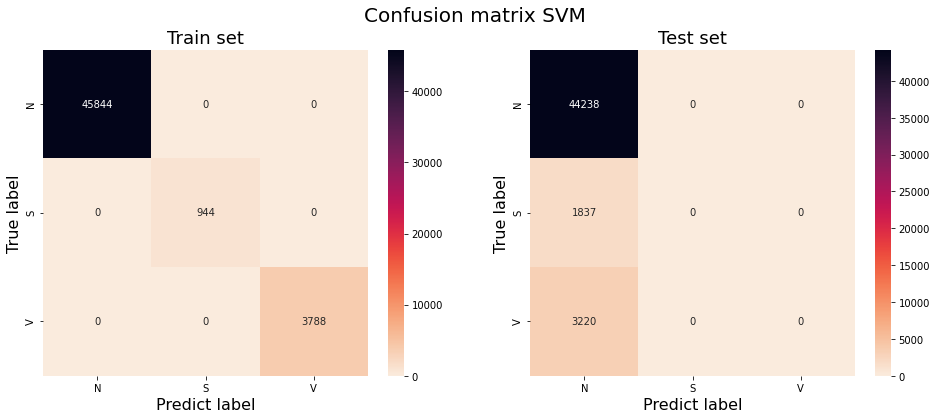

In [136]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_svm = confusion_matrix(y_train,train_pred_svm,labels=svm_scaler.classes_)
matrix_test_svm = confusion_matrix(y_test,test_pred_svm,labels=svm_scaler.classes_)

sns.heatmap(matrix_train_svm, ax=ax[0],
            xticklabels=svm_scaler.classes_, 
            yticklabels=svm_scaler.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_svm, ax=ax[1],
            xticklabels=svm_scaler.classes_, 
            yticklabels=svm_scaler.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix SVM', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

In [40]:
dec_funct_xgb = xgboost.predict_proba(X_t)
dec_funct_grd = grdboost.decision_function(X_t)
dec_funct_svm = svm_scaler.decision_function(X_t)
dec_funct_ann = model.predict_proba(X_t)

/media/share/comum/env/nevasca/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


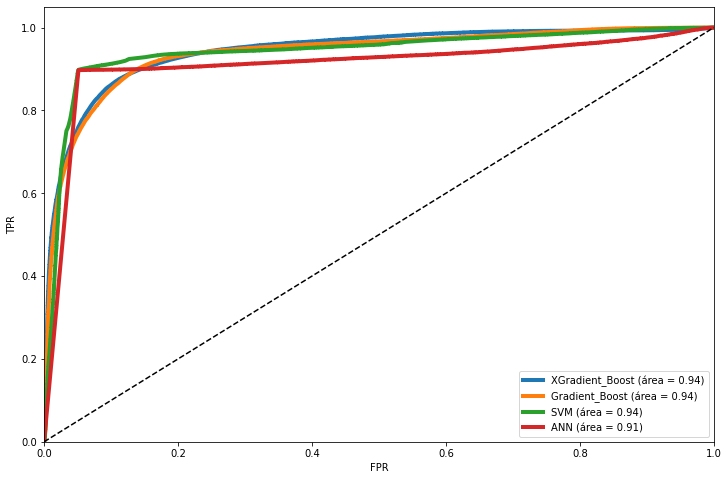

In [44]:
classifiers = ['XGradient_Boost','Gradient_Boost','SVM', 'ANN']
dec_functs = [dec_funct_xgb, dec_funct_grd, dec_funct_svm, dec_funct_ann]

plot_all_roc_auc_curves(dummy_y_test, dec_functs, classifiers)